### Library Import

In [160]:
import pandas as pd
import numpy as np
import os

from models.utility import load_input, scale_with_minmax, get_dates_from_config, handle_outliers, \
    get_params_from_config, dailydf_to_ts, inverse_transform_minmax, transform_dayofyear, write_DWH
from models.lstm import simpleLSTM
from models.deeplearner import DeepLearner

from solutil import evaluations

### Input Preparation

In [161]:
# Define global variables
str_model = 'inlet3_lstm'

In [162]:
# Load Input Parameters
dates = get_dates_from_config(str_model)
df_variables = load_input(str_model=str_model, **dates)

base
base_1d
useday_1d
temp_1h
glob_1h
rain_1h
bf15_1h
schmelz_1h


In [163]:
df_variables

,base_lag0,base_1d_lag0,temp_1h_lag0,temp_1h_lag1,glob_1h_lag1,glob_1h_lag2,glob_1h_lag3,rain_1h_lag0,rain_1h_lag1,bf15_1h_lag0,schmelz_1h_lag0,schmelz_1h_lag1
2021-08-01 00:00:00+01:00,2.340147,2.470193,8.922500,9.867500,0.000000,66.439583,117.885417,3.735000,2.34750,1.458325,0.000000,0.000000
2021-08-01 04:00:00+01:00,2.661687,2.470193,7.712500,8.922500,0.000000,0.000000,66.439583,2.816250,3.73500,1.464125,0.000000,0.000000
2021-08-01 08:00:00+01:00,2.533353,2.470193,7.567500,7.712500,17.493750,0.000000,0.000000,0.442500,2.81625,1.455575,0.000000,0.000000
2021-08-01 12:00:00+01:00,2.445644,2.470193,8.265000,7.567500,170.097917,17.493750,0.000000,1.152500,0.44250,1.454975,0.000000,0.000000
2021-08-01 16:00:00+01:00,2.495640,2.470193,7.762500,8.265000,214.900000,170.097917,17.493750,0.730833,1.15250,1.447275,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-08 08:00:00+01:00,2.302622,2.281618,13.412500,9.864583,114.825000,0.803125,0.313542,0.000000,0.00000,1.237396,0.453333,0.245833
2024-07-08 12:00:00+01:00,1.845461,2.281618,16.933333,13.412500,719.688542,114.825000,0.803125,0.000000,0.00000,1.224521,0.471250,0.453333
2024-07-08 16:00:00+01:00,2.793377,2.281618,16.300000,16.933333,727.798958,719.688542,114.825000,0.000000,0.00000,1.215958,0.317917,0.471250
2024-07-08 20:00:00+01:00,2.437834,2.281618,13.145833,16.300000,184.682292,727.798958,719.688542,0.000000,0.00000,1.211354,0.207083,0.317917


In [164]:
df_doy = transform_dayofyear(df_variables)

There are some outliers in the data, as can be seen from the following plot.

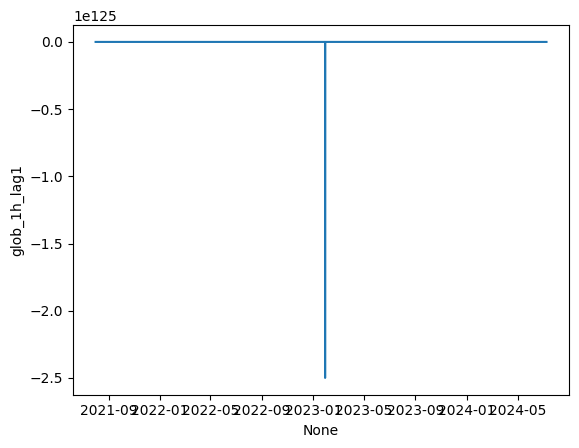

In [165]:
import seaborn as sns

fig = sns.lineplot(x=df_variables.index, y=df_doy['glob_1h_lag1'])

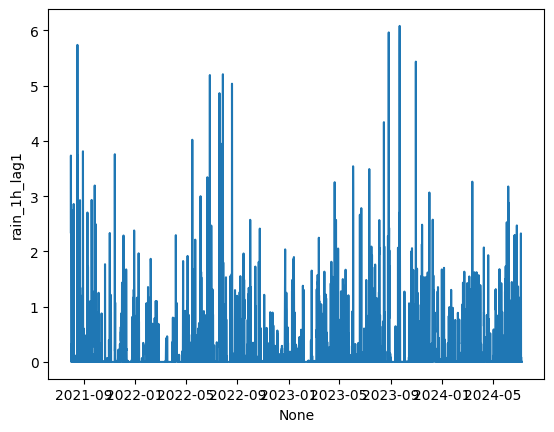

In [166]:
fig = sns.lineplot(x=df_variables.index, y=df_variables['rain_1h_lag1'])

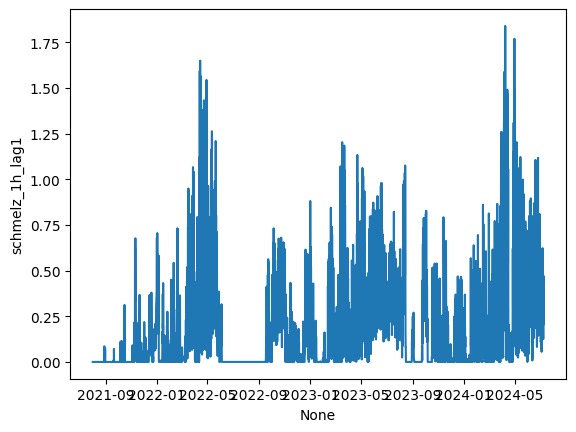

In [167]:
fig = sns.lineplot(x=df_variables.index, y=df_variables['schmelz_1h_lag1'])

In [168]:
# Handle outliers
df_handled = handle_outliers(df_doy)

Variable base_lag0
Variable base_1d_lag0
Variable temp_1h_lag0
Variable temp_1h_lag1
Variable glob_1h_lag1
Variable glob_1h_lag2
Variable glob_1h_lag3
Variable rain_1h_lag0
Variable rain_1h_lag1
Variable bf15_1h_lag0
Variable schmelz_1h_lag0
Variable schmelz_1h_lag1
Variable yearday_sin
Variable yearday_cos


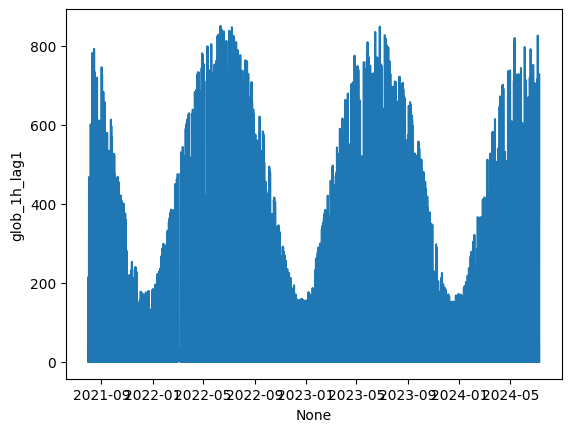

In [169]:
fig = sns.lineplot(x=df_handled.index, y=df_handled['glob_1h_lag1'])

In [170]:
# Scale inputs
df_scaled = scale_with_minmax(df_handled, str_model, verbose=0)

In [171]:
# Initialize lstm class
lstm = simpleLSTM()
deepl = DeepLearner()

In [172]:
# Generate sequences
n_lookback = 20
n_ahead = 6
n_offset = 0
target_var = 'base_lag0'

df_seq = lstm.generate_sequences(df_scaled, target_var, n_lookback, n_ahead, n_offset, continuous=False)

Length df_x: 6391 - length df_y: 6391


In [173]:
lstm.ytest_startdate

Timestamp('2023-08-24 08:00:00+0100', tz='Etc/GMT-1')

In [174]:
# Save variables
x_train = df_seq[0]
x_test = df_seq[1]
y_train = df_seq[2]
y_test = df_seq[3]

In [175]:
x_train.shape

(742, 20, 13)

### Model Initiation & Training

#### Grid Search

In [176]:
# Grid Search hyperparameters
hyperparams = {
    'units_l1': [500, 750, 1000],
    'units_l2': [500, 750, 100],
    'dropout_l1': [0.1, 0.2],
    'dropout_l2': [0.1, 0.2],
    'activation_l1': ["tanh"],
    'activation_l2': ['tanh']
}

lookback_periods = [20]

lookback_dict = deepl.get_grid_train_dict(lookback_periods, df_scaled, target_var) # kwargs possible

Length df_x: 6391 - length df_y: 6391


In [ ]:
results, best_model = deepl.grid_search_lstm(lookback_dict, hyperparams)
print(f"best model: {best_model}")

35it [1:32:43, 198.62s/it]

In [ ]:
results.to_csv('experiments/inlet3_lstm_gridsearch_fine.csv')

The optimum model is configured with the option 55, representing the following specifics: 

{'units_l2': 200,
 'units_l1': 200,
 'dropout_l2': 0.2,
 'dropout_l1': 0.1,
 'activation_l2': 'tanh',
 'activation_l1': 'tanh'}

 However, the old configuration of the inlet1_lstm model is kept to simplify the model overview since the performance difference between the optimal configuration (55) and the inlet1 configuration (53) is negligible in terms of MSE, while the inlet1 config even performs better during validation. 

In [ ]:
# Retrieve optimal model parameters
from sklearn.model_selection import ParameterGrid
option_grid = ParameterGrid(hyperparams)
opt_config = option_grid[53]

In [ ]:
lstm_2l = lstm.build_2layer_lstm(x_train, y_train, **opt_config) # lstm.build_2layer_bidirectional_lstm(x_train, y_train, **opt_config)

#### Train Final Model

In [ ]:
# Get training parameters
train_params = get_params_from_config(function='model_train', str_model=str_model)

In [ ]:
# Train Model
trained_lstm, lstm_hist = deepl.train_model(x_train, y_train, lstm_2l, **train_params, verbose_int=1)

In [ ]:
y_pred = trained_lstm.predict(x_test)

### Model Evaluation

In [ ]:
# Rescale predictions
print(str_model)
y_pred = inverse_transform_minmax(y_pred, str_model, ['base_lag0'])
y_test = inverse_transform_minmax(y_test, str_model, ['base_lag0']) 

In [ ]:
# Convert prediction to df
start_date = None #'01.01.2024 00:00:00'
n_timestep = None # 1

df_ypred = lstm.convert_seq_to_df(y_pred, n_timestep=n_timestep, start_date=start_date)

In [ ]:
# Convert test seq to df
df_ytest = lstm.convert_seq_to_df(y_test, start_date=start_date, n_timestep=n_timestep)

In [ ]:
# Convert df to time series
ts_ypred = dailydf_to_ts(df_ypred)
ts_ytest = dailydf_to_ts(df_ytest)

In [ ]:
ts_ytest

In [ ]:
# Calculate metrics
evaluations.get_eval_metrics(ts_ytest, ts_ypred)

In [ ]:
evaluations.get_act_vs_pred_plot(ts_ytest, ts_ypred)

### Save Model Output for Ensemble

In [ ]:

data_dict = {'ypred_lstm': ts_ypred,
            'ytest': ts_ytest}

df_data = pd.DataFrame(data_dict)

#df_data.to_csv('experiments/stacking_data/ypred_lstm.csv')


In [ ]:
#df_variables.to_csv('experiments/stacking_data/features_lstm.csv')

### Save Model Output for Ensemble

In [ ]:
# Interpolate to 1h frequency
ts_ypred_1h = ts_ypred.resample('1h').interpolate()
df_ypred_1h = ts_ypred_1h.to_frame()

In [ ]:
# Create ts name string
inlet_n = str_model.split('_')[0].capitalize()
str_algo = str_model.split('_')[1].upper()
str_pred = 'Prediction'
ts_name = '_'.join([inlet_n, str_pred, str_algo])

In [ ]:
ts_name

In [ ]:
# Save as csv
'''
write_DWH(str_path=os.path.join(r'\\srvedm11', 'Import', 'Messdaten', 'EPAG_Energie', 'DWH_EX_60'),
          str_tsname=ts_name,
          str_property="Python",
          str_unit='m/3',
          df_timeseries = df_ypred_1h
          )
'''

In [ ]:
ts_ypred

In [ ]:
results['rank'] = (results['mse'].rank() + results['val_loss'].rank()).rank()
opt_index = results.sort_values(by='rank').head(10).index

In [ ]:
opt_index

In [ ]:
for option in opt_index:
    option = option - 144 if option > 144 else option
    print(f"{option}: {option_grid[option]}")